### Neuroevolution:
- Bild -> preprocessing -> CNN -> MLP -> Eingabe (NES controller)
- CNN und MLP basieren auf pytorch
- CNN und MLP werden gemeinsam mutiert, die mutation vom agenten der am weitesten kam wird übernommen
- Distanz vom Start wird (fürs erste) der einzige reward sein

#### ToDo:
- Dynamische Mutation (z.B: erhöhe Mutationsstärke bei Stillstand)
- Models müssen gespeichert und geladen werden können
- Gespeicherte models nochmal finetunen, testen, überüfen ob die wirklich konstant gute Ergebnisse haben
- Pupulationsize und ggf. andere Hyperparameter direkt im plot angeben

#### Elitismus:
- die n besten agenten bleiben erhalten
- wähle gesamt-n agenten mit wheel selection aus (also proportional zur fitness haben fittere agenten eine höhrere w.keit ausgewählt zu werden, vermeide das "super Agenten" die w.keitsverteilung zerstören, das rad wird also gewollt oft gedreht und vom sieger wird eine mutation erstellt)
- mutiere die gesamt minus n zufällig ausgewählten agenten die dann teil der nächsten generation sind

#### Nice to have:
- Verbesserung der GPU Auslastung (Hat sich als schwierig herausgestellt, im Moment ist cpu-only schneller!)
- Frame skipping um performance zu erhöhen (Auch schwierig hauptlast ist nicht die entscheidung des agenten sondern die laufende mario umgebung)

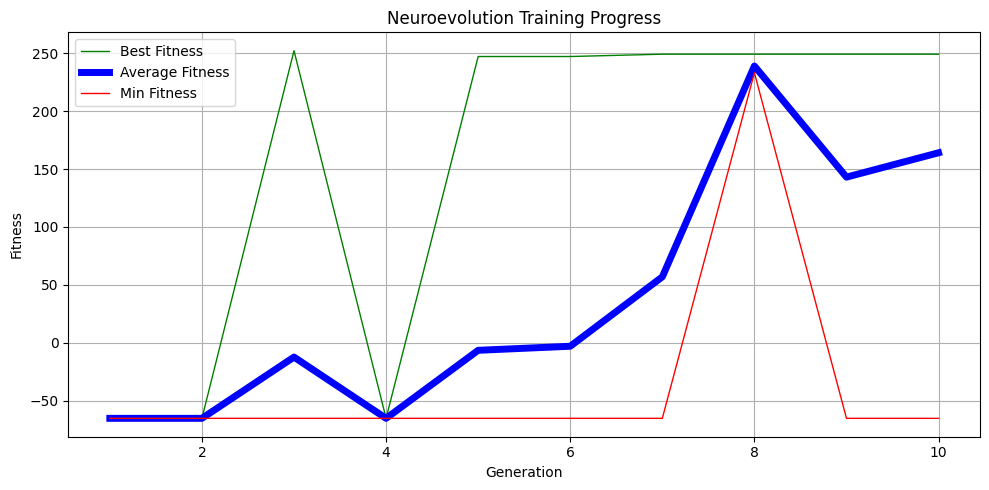

Generation: 10 / 10

Alltime best: 252.00


/Users/babajane/Library/Python/3.9/lib/python/site-packages/gym/wrappers/record_video.py:75: UserWarning: WARN: Overwriting existing videos at /Users/babajane/Library/Mobile Documents/com~apple~CloudDocs/realRoot/uni/mac/6Semester/cognitiveComputing/SuperMarioReinforcementLearningProject/media/videos folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(
/Users/babajane/Library/Python/3.9/lib/python/site-packages/gym/wrappers/monitoring/video_recorder.py:57: DeprecationWarning: WARN: `env.metadata["render.modes"] is marked as deprecated and will be replaced with `env.metadata["render_modes"]` see https://github.com/openai/gym/pull/2654 for more details
  logger.deprecation(
/Users/babajane/Library/Python/3.9/lib/python/site-packages/gym/wrappers/monitoring/video_recorder.py:130: DeprecationWarning: WARN: `env.metadata["video.frames_per_second"] is marked as deprecated and will be replaced with `env.metadata["render_fps"]` 


Running best agent for recording...

Final fitness: 252.00
Video saved to: ../media/videos


In [1]:
import torch
from src.non_reinforcement.neuroevolution.neuroevolution_trainer import NeuroevolutionTrainer
from src.non_reinforcement.neuroevolution.neuroevolution_net import NeuroevolutionNet
from gym_super_mario_bros.actions import COMPLEX_MOVEMENT

DEVICE = "cpu"  #torch.device("cuda" if torch.cuda.is_available() else "cpu")

cnn_config = [
    {"out_channels": 16, "kernel_size": 8, "stride": 4},
    {"out_channels": 32, "kernel_size": 4, "stride": 2},
]

mlp_config = [
    32 * 9 * 9,  # Must match flattened output of CNN
    256,
    128,
    len(COMPLEX_MOVEMENT)
]

model = NeuroevolutionNet(
    input_channels=1,
    num_actions=len(COMPLEX_MOVEMENT),
    cnn_config=cnn_config,
    mlp_config=mlp_config
)

trainer = NeuroevolutionTrainer(
    base_model=model,
    env_name='SuperMarioBros-v0',
    action_set=COMPLEX_MOVEMENT,
    device=DEVICE,
    video_dir="../media/videos",
    generations=10,
    population_size=6,
    max_steps_per_episode=500,
    mutation_rate=0.05,
    mutation_strength=0.1
)

trainer.run()
trainer.record_best_agent()